In [1]:
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
quote = Quote(screen_funds('Commodities', min_assets=.2), 75, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

from 2019-04-25 to 2019-07-09 - 21


In [3]:
stats = quote.statistics()
stats = stats[stats['shrp'] > 0]
print(len(stats))
stats

10


,len,mean,std,shrp,yield,drawdown
Symbols,,,,,,
BAR,47,1.004102,1.886833,0.511132,9.340664,2.700990
GLD,47,0.993981,1.880347,0.507512,9.272622,2.667662
SGOL,47,0.998193,1.895860,0.505581,9.307236,2.692057
IAU,47,0.998547,1.918676,0.499753,9.239576,2.716592
GLTR,47,0.714487,1.724557,0.391292,5.762872,3.584793
PALL,47,1.279616,3.259464,0.380410,9.452889,11.245765
PSLV,47,0.542643,1.972228,0.255021,4.452695,4.805911
DBA,47,0.319966,1.689790,0.165869,2.779486,4.012349
SIVR,47,0.179332,1.720579,0.081164,1.101927,4.517453


/Users/chaoyi/.local/share/virtualenvs/portfolio_analysis-bdMx2S3t/lib/python3.7/site-packages/scipy/optimize/optimize.py:2341: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


evicted PSLV 0.867 -0.240
retry backlogs ['GLTR', 'SLV', 'IAU', 'SGOL', 'GLD', 'SIVR'] at 0.905 - 0.621
evicted SIVR 0.864 -0.281
retry backlogs ['GLTR', 'IAU', 'SGOL', 'SLV', 'GLD'] at 0.91 - 0.621
evicted SLV 0.870 -0.284
retry backlogs ['GLTR', 'IAU', 'SGOL', 'GLD'] at 0.915 - 0.621
retry backlogs ['GLTR', 'SGOL', 'IAU', 'GLD'] at 0.92 - 0.621
retry backlogs ['GLTR', 'SGOL', 'IAU', 'GLD'] at 0.925 - 0.621
retry backlogs ['GLTR', 'SGOL', 'IAU', 'GLD'] at 0.93 - 0.621
retry backlogs ['GLTR', 'SGOL', 'IAU', 'GLD'] at 0.935 - 0.621
retry backlogs ['GLTR', 'SGOL', 'IAU', 'GLD'] at 0.9400000000000001 - 0.621
retry backlogs ['GLTR', 'SGOL', 'IAU', 'GLD'] at 0.9450000000000001 - 0.621
retry backlogs ['GLTR', 'SGOL', 'IAU', 'GLD'] at 0.9500000000000001 - 0.621
retry backlogs ['GLTR', 'SGOL', 'IAU', 'GLD'] at 0.9550000000000001 - 0.621
evicted GLTR 0.952 -0.185
retry backlogs ['SGOL', 'IAU', 'GLD'] at 0.9600000000000001 - 0.621
retry backlogs ['SGOL', 'IAU', 'GLD'] at 0.9650000000000001 - 0.6

,count,mean,std,min,25%,50%,75%,max,shrp,yield,drawdown
Portfolio,47.0,0.799602,1.236530,-1.500611,-0.384485,1.004176,1.626682,3.382531,0.614558,7.193371,2.363634
BAR,47.0,1.004102,1.886833,-2.494698,0.000000,0.549017,1.564185,5.833955,0.511132,9.340664,2.700990
PALL,47.0,1.279616,3.259464,-6.910482,-1.122923,1.428178,3.339326,7.906003,0.380410,9.452889,11.245765
DBA,47.0,0.319966,1.689790,-3.039707,-0.864284,0.000000,1.955462,3.729897,0.165869,2.779486,4.012349


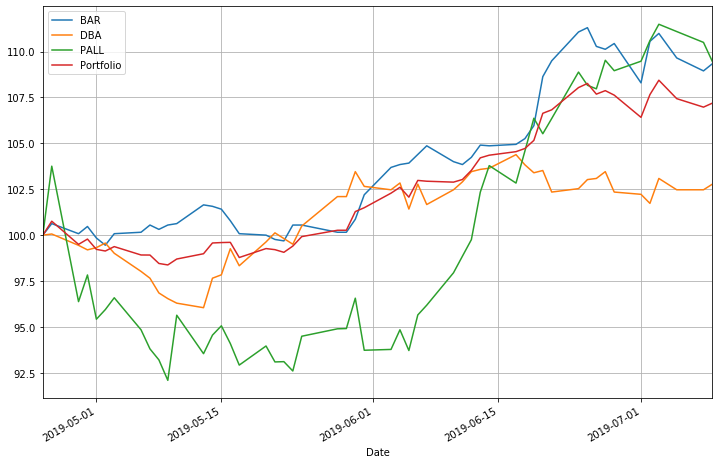

In [4]:
quote.setup_mask(stats.index)
ratio, shrp = quote.optimize_portfolio(.1)
print(ratio, shrp)
quote.setup_mask(ratio)
quote.graph(ratio)